<a href="https://colab.research.google.com/github/sekunder/NMA_Project/blob/master/Decoding%20Orientation%20Models_GLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
#@title Data loading2

import os, requests
import numpy as np
import pandas as pd

# give google colab access to your drive
from google.colab import drive
drive.mount('/content/drive')

wd="drive/My Drive/data/"

all_fnames = ['gratings_noisy_GT1_2019_04_08_1.npy', \
          'gratings_static_GT1_2019_04_17_1.npy',\
          'minnie_GT1_2019_04_29_2.npy',\
          'gratings_drifting_GT1_2019_04_12_1.npy',\
          'gratings_local_GT1_2019_04_27_2.npy']
fname_keys = ['noisy', 'static', 'minnie', 'drifting', 'local']

#@title Helper functions

def plot_stim_and_spikes(stim, spikes, dt, nt=120):
  """Show time series of stim intensity and spike counts.

  Args:
    stim (1D array): vector of stimulus intensities
    spikes (1D array): vector of spike counts
    dt (number): duration of each time step
    nt (number): number of time steps to plot

  """
  timepoints = np.arange(120)
  time = timepoints * dt

  f, (ax_stim, ax_spikes) = plt.subplots(
    nrows=2, sharex=True, figsize=(8, 5),
  )
  ax_stim.plot(time, stim[timepoints])
  ax_stim.set_ylabel('Stimulus intensity')

  ax_spikes.plot(time, spikes[timepoints])
  ax_spikes.set_xlabel('Time (s)')
  ax_spikes.set_ylabel('Number of spikes')

  f.tight_layout()


def plot_glm_matrices(X, y, nt=50):
  """Show X and Y as heatmaps.
    
  Args:
    X (2D array): Design matrix.
    y (1D or 2D array): Target vector.

  """
  from matplotlib.colors import BoundaryNorm
  from mpl_toolkits.axes_grid1 import make_axes_locatable
  Y = np.c_[y]  # Ensure Y is 2D and skinny

  f, (ax_x, ax_y) = plt.subplots(
    ncols=2,
    figsize=(6, 8),
    sharey=True,
    gridspec_kw=dict(width_ratios=(5, 1)),
  )
  norm = BoundaryNorm([-1, -.2, .2, 1], 256)
  imx = ax_x.pcolormesh(X[:nt], cmap="coolwarm", norm=norm)
  
  ax_x.set(
    title="X\n(lagged stimulus)",
    xlabel="Time lag (time bins)",
    xticks=[4, 14, 24],
    xticklabels=['-20', '-10', '0'],
    ylabel="Time point (time bins)",
  )
  plt.setp(ax_x.spines.values(), visible=True)

  divx = make_axes_locatable(ax_x)
  caxx = divx.append_axes("right", size="5%", pad=0.1)
  cbarx = f.colorbar(imx, cax=caxx)
  cbarx.set_ticks([-.6, 0, .6])
  cbarx.set_ticklabels(np.sort(np.unique(X)))

  norm = BoundaryNorm(np.arange(y.max() + 1), 256)
  imy = ax_y.pcolormesh(Y[:nt], cmap="magma", norm=norm)
  ax_y.set(
    title="Y\n(spike count)",
    xticks=[]
  )
  ax_y.invert_yaxis()
  plt.setp(ax_y.spines.values(), visible=True)

  divy = make_axes_locatable(ax_y)
  caxy = divy.append_axes("right", size="30%", pad=0.1)
  cbary = f.colorbar(imy, cax=caxy)
  cbary.set_ticks(np.arange(y.max()) + .5)
  cbary.set_ticklabels(np.arange(y.max()))

def plot_spike_filter(theta, dt, **kws):
  """Plot estimated weights based on time lag model.

  Args:
    theta (1D array): Filter weights, not including DC term.
    dt (number): Duration of each time bin.
    kws: Pass additional keyword arguments to plot()

  """
  d = len(theta)
  t = np.arange(-d + 1, 1) * dt

  ax = plt.gca()
  ax.plot(t, theta, marker="o", **kws)
  ax.axhline(0, color=".2", linestyle="--", zorder=1)
  ax.set(
    xlabel="Time before spike (s)",
    ylabel="Filter weight",
  )


def plot_spikes_with_prediction(
    spikes, predicted_spikes, dt, nt=50, t0=120, **kws):
  """Plot actual and predicted spike counts.

  Args:
    spikes (1D array): Vector of actual spike counts
    predicted_spikes (1D array): Vector of predicted spike counts
    dt (number): Duration of each time bin.
    nt (number): Number of time bins to plot
    t0 (number): Index of first time bin to plot.
    kws: Pass additional keyword arguments to plot()

  """
  t = np.arange(t0, t0 + nt) * dt

  f, ax = plt.subplots()
  lines = ax.stem(t, spikes[:nt], use_line_collection=True)
  plt.setp(lines, color=".5")
  lines[-1].set_zorder(1)
  kws.setdefault("linewidth", 3)
  yhat, = ax.plot(t, predicted_spikes[:nt], **kws)
  ax.set(
      xlabel="Time (s)",
      ylabel="Spikes",
  )
  ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
  ax.legend([lines[0], yhat], ["Spikes", "Predicted"])

  plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
#@title Figure settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

In [12]:
#@title Data loading
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.io import loadmat
# load this mouse's data
dats={}
# which files do you want to load?
idx = [1]
# load each file and save it in a new array
for ind in idx:
  dats[fname_keys[ind]] = np.load(os.path.join(wd, all_fnames[ind]), allow_pickle=True).item()

# main dataset to test
dat=dats['static']

In [13]:
#prepping data for GLM - for each istim angle, we wnt the firing rate per neurond

print(dat.keys())
print(dat['istim'].shape)
print(dat['sresp'].shape)

dict_keys(['sresp', 'istim', 'stat', 'u_spont', 'v_spont', 'mean_spont', 'std_spont', 'stimtimes', 'frametimes', 'camtimes'])
(4598,)
(23589, 4598)


In [25]:
spikes = dat['istim']

resp = dat['sresp'].T

print(len(spikes))
print(len(resp))

print(spikes)
print(spikes%np.pi)

4598
4598
[2.62022653e+00 4.52593227e+00 7.18638172e-04 ... 2.76552240e+00
 6.66378931e-01 5.51212615e+00]
[2.62022653e+00 1.38433962e+00 7.18638172e-04 ... 2.76552240e+00
 6.66378931e-01 2.37053350e+00]


Attempt to GLM

In [26]:
from sklearn import linear_model
import datetime 

start = datetime.datetime.now() 
print(start)

clf = linear_model.LinearRegression(copy_X=True, fit_intercept=True, normalize=False)

clf.fit (resp, stim)

print(clf.coef_)

end = datetime.datetime.now() 
print(end - start)



KeyboardInterrupt: ignored

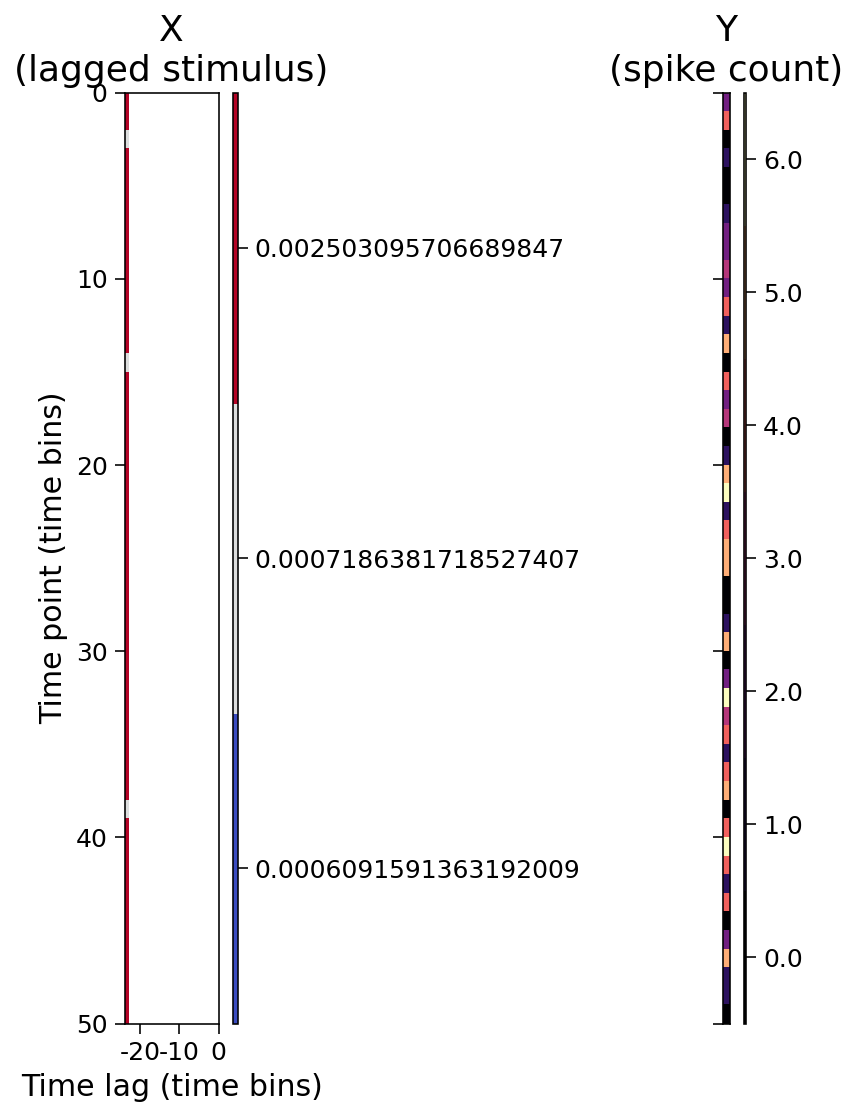

In [30]:
def make_design_matrix(stim, d=1):
  """Create time-lag design matrix from stimulus intensity vector.
  Args:
    stim (1D array): Stimulus intensity at each time point.
    d (number): Number of time lags to use.
  Returns
    X (2D array): GLM design matrix with shape T, d
  """
  # Create version of stimulus vector with zeros before onset
  padded_stim = np.concatenate([np.zeros(d - 1), stim])

  # Construct a matrix where each row has the d frames of
  # the stimulus proceeding and including timepoint t
  T = len(stim)  # Total number of timepoints
  X = np.zeros((T, d))
  for t in range(T):
      X[t] = padded_stim[t:t + d]

  return X


X = make_design_matrix(stim)
plot_glm_matrices(X, spikes, nt=50)

In [34]:
#Get weights
# Build the full design matrix
y = spikes
constant = np.ones_like(y)
X = np.column_stack([constant, make_design_matrix(stim)])

# Get the MLE weights for the LG model
theta = np.linalg.inv(X.T @ X) @ X.T @ y
theta_lg = theta[1:]

plot_spike_filter(theta_lg, dt_stim)

NameError: ignored

**180 - PCAs **

Data = dat --> transoform collums 'istim' such that it is 180degrees rather than 360. 

In [ ]:
from copy import deepcopy as dc 

dat_180 = dc(dat)

dat_180['istim'] = dat['istim']%np.pi


[2.62022653e+00 4.52593227e+00 7.18638172e-04 ... 2.76552240e+00
 6.66378931e-01 5.51212615e+00]
[2.62022653e+00 1.38433962e+00 7.18638172e-04 ... 2.76552240e+00
 6.66378931e-01 2.37053350e+00]


In [ ]:
#@title PCA functions
n_cmp = 20
import matplotlib 
from matplotlib import pyplot as plt
from scipy.signal import butter, filtfilt
from scipy.stats import zscore
from sklearn.decomposition import PCA 

def run_pca(dat_180, zs=True, n_cmp=n_cmp):
  if zs:
    Z = zscore(dat_180['sresp'], axis=1)
  else:
    Z = dat_180['sresp']
  p = PCA(n_components = n_cmp)
  p.fit_transform(Z.T)
  X = p.components_@Z
  return p, X

def plot_pca_weights(dat_180, istim, X, n_cmp=n_cmp):
  b,a = butter(4, [0.05], 'lowpass') #creating a low pass butterworth filter
  idx = np.argsort(dat_180['istim'])
  fig = plt.figure(figsize = (15,10))
  for j in np.arange(n_cmp):
      ax = fig.add_subplot(4,5,j+1,polar = True)
      plt.plot(dat_180['istim'][idx],filtfilt(b,a,X[j,idx]))
      #plt.scatter(dat_180['istim'][idx],X[j,idx])
      plt.title('PC %d\n' %j, loc='center', pad=-85)
      ax.set_thetamin(0)
      ax.set_thetamax(180)
  plt.show()

def run_pca_and_plot(dat_180, zs=True, n_cmp=n_cmp):
  # PCA
  _, X = run_pca(dat_180, zs, n_cmp)
  # Plot
  plot_pca_weights(dat_180, dat_180['istim'], X, n_cmp)

In [ ]:
# run PCA and plot weights for static images - assign variable X
# run_pca_and_plot(dats['static'])

# PCA
_, X = run_pca(dat_180, zs=True, n_cmp=n_cmp)


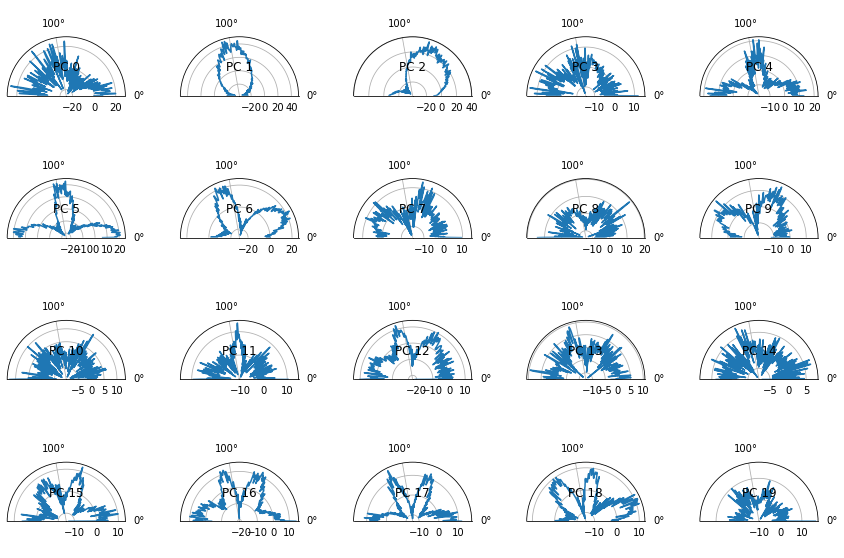

In [ ]:
# Plot
plot_pca_weights(dat_180, dat_180['istim'], X, n_cmp)

***Up to here ... rest is not functional ***

In [ ]:
# run PCA and plot weights for static images
run_pca_and_plot(['static'])

TypeError: ignored

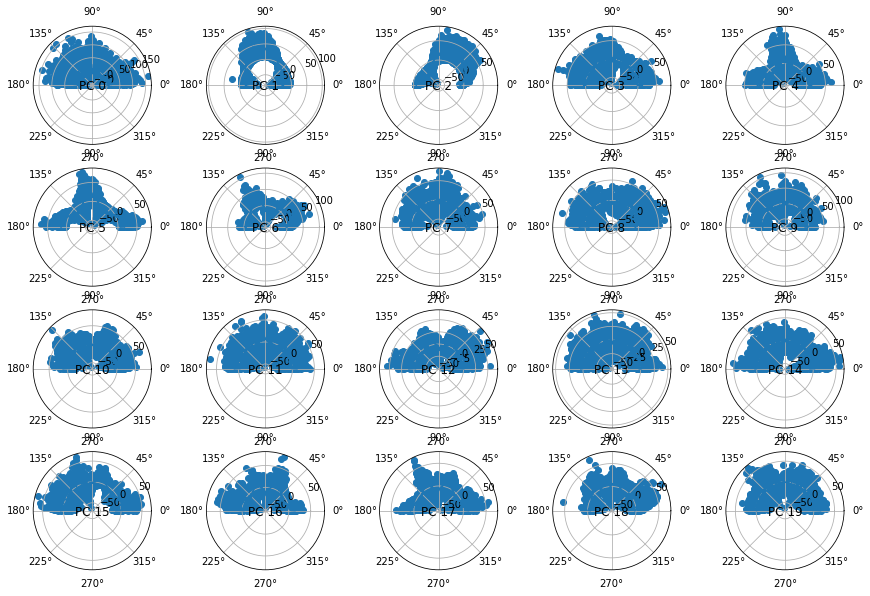

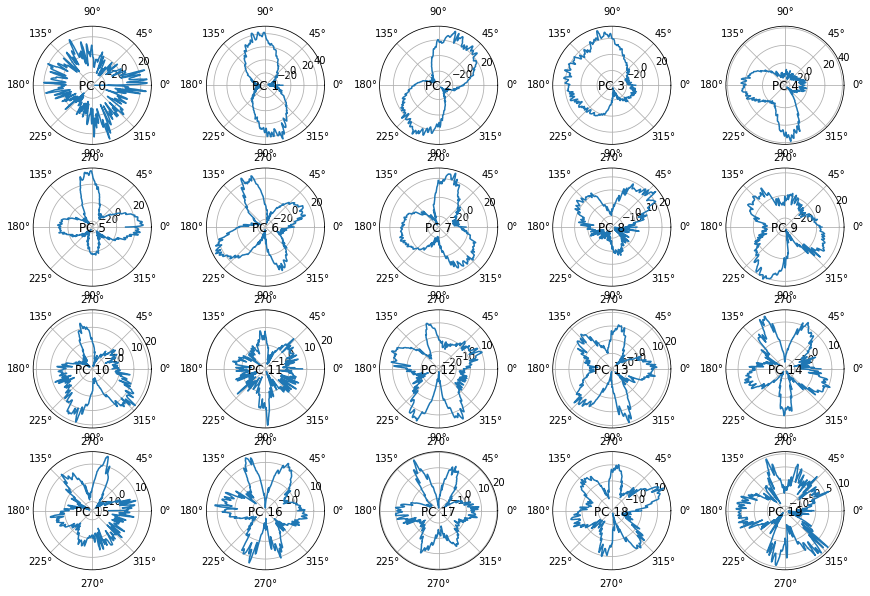

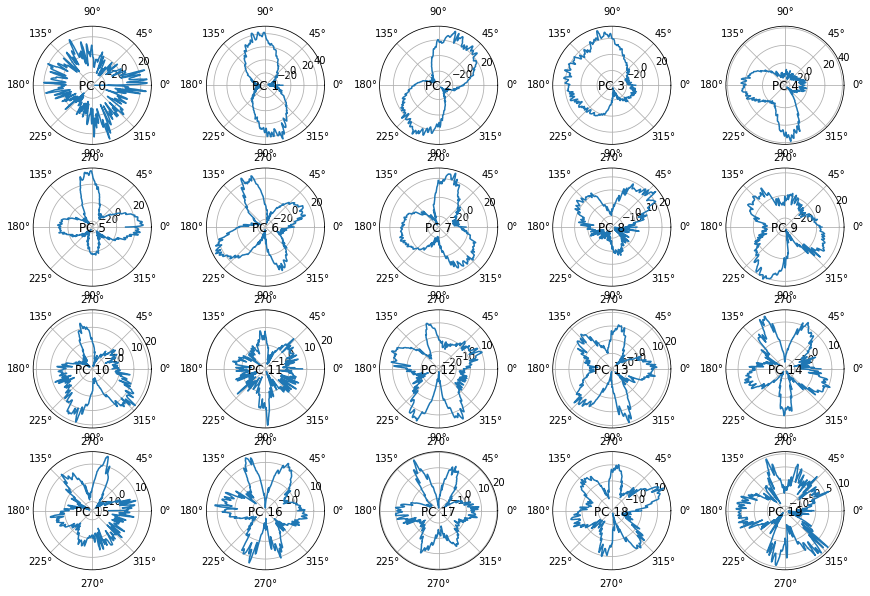

In [ ]:
# run PCA and plot weights for static images - assign variable X - reduce stim to 180 (rather than 360)
# run_pca_and_plot(dats['static'])

data = dats['static']

#dat['istim']%np.pi
data_angles = dat['istim']
data_angles_b = dat['istim']%np.pi

# PCA
_, X = run_pca(data, zs=True, n_cmp=n_cmp)
# Plot
plot_pca_weights(dat, data_angles, X, n_cmp)

plot_pca_weights(dat, data_angles_b, X, n_cmp)

In [ ]:
#@ Store (x,y) positions of each neuron
tp = np.zeros(((dat['sresp'].shape[1]),2))
for k in range(dat['sresp'].shape[1]):
    tp[k,:] = np.array([dat['stat'][k]['xpix'].mean(),dat['stat'][k]['ypix'].mean()])

In [ ]:
#@ Split the data into training (2/3) and testing (1/3)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X.T, dat['istim'])
print('Training data size = ', X_train.shape)
print('Training target size = ', y_train.shape)
print('Testing data size = ', X_test.shape)
print('Testing target size = ', y_test.shape)

Training data size =  (3448, 20)
Training target size =  (3448,)
Testing data size =  (1150, 20)
Testing target size =  (1150,)


In [ ]:
from sklearn.linear_model import LinearRegression
mod = LinearRegression()
mod.fit(X_train, y_train)

LinearRegression()

In [ ]:
def plot_model_results(output_train, y_train, output_test, y_test):
    from matplotlib import pyplot as plt
    from scipy.stats import circmean, pearsonr
    fig = plt.figure()
    #@ Training data
    idx = np.argsort(y_train.T)
    fig.add_subplot(1,2,1,polar = True)
    plt.polar(output_train[idx],np.arange(len(output_train)),'.')
    plt.polar(y_train[idx],np.arange(len(output_train)),'.',markersize = 2, alpha = 1)
    plt.title('Training\n')

    x = np.sin(output_train - circmean(output_train))
    y = np.sin(y_train - circmean(y_train))
    acc1 = pearsonr(x,y)[0]**2

    #@ Testing data
    idx = np.argsort(y_test.T)
    fig.add_subplot(1,2,2,polar = True)
    plt.polar(output_test[idx],np.arange(len(output_test)),'.')
    plt.polar(y_test[idx],np.arange(len(output_test)),'.',markersize = 2, alpha = 1)
    plt.title('Testing\n')

    x = np.sin(output_test - circmean(output_test))
    y = np.sin(y_test - circmean(y_test))
    acc2 = pearsonr(x,y)[0]**2

    print('Training r^2: ',f'{acc1:.2f}')
    print('Testing r^2: ',f'{acc2:.2f}')
    
    return None

Training r^2:  0.81
Testing r^2:  0.76


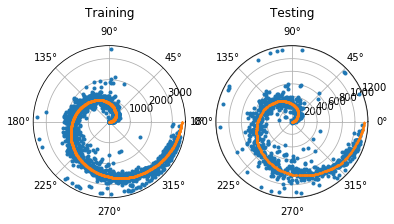

In [ ]:
from sklearn.neural_network import MLPRegressor
mod2 = MLPRegressor(solver='lbfgs',activation= 'tanh' , alpha=1e-5, hidden_layer_sizes=(20,1), random_state=1, max_iter = 1e4)
mod2.fit(X_train, y_train)
plot_model_results(mod2.predict(X_train), y_train, mod2.predict(X_test), y_test)

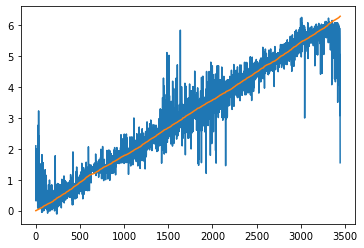

In [ ]:
plt.plot(mod2.predict(X_train)[idx])
plt.plot(y_train[idx])

In [ ]:
idx = np.argsort(y_train)
y_train_2d = np.zeros((len(y_train),2))
y_train_2d[:,0], y_train_2d[:,1] =  np.cos(y_train) ,  np.sin(y_train)

y_test_2d = np.zeros((len(y_test),2))
y_test_2d[:,0], y_test_2d[:,1] =  np.cos(y_test) ,  np.sin(y_test)

Training r^2:  0.97
Testing r^2:  0.92


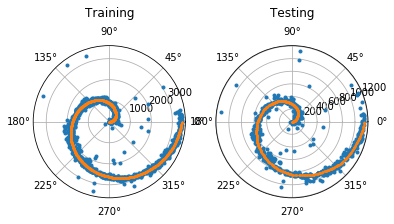

In [ ]:
from sklearn.neural_network import MLPRegressor
mod3 = MLPRegressor(solver='lbfgs',activation= 'tanh' , alpha=1e-5, hidden_layer_sizes=(20,2), random_state=1, max_iter = 1e3)
mod3.fit(X_train, y_train_2d)
o1 = mod3.predict(X_train)
o2 = mod3.predict(X_test)
plot_model_results(np.arctan2(o1[:,1], o1[:,0]), y_train, np.arctan2(o2[:,1], o2[:,0]), y_test)

(0, 76.63333333333334)

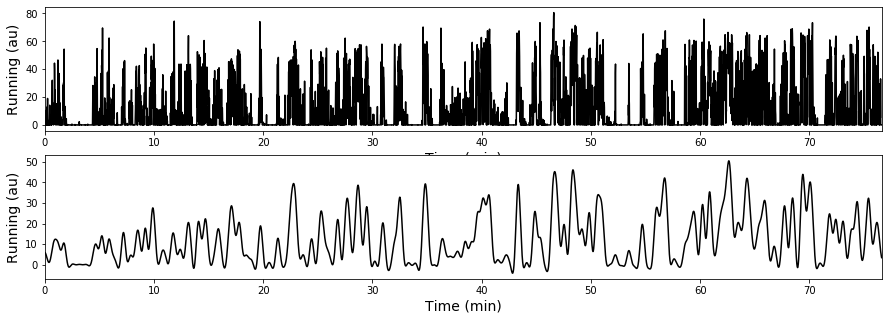

In [ ]:
fig = plt.figure(figsize = (15,5))
[b,a] = butter(4, 0.05, 'lowpass')
plt.subplot(2,1,1)
plt.plot(np.arange(len(dat['run']))/60, dat['run'], 'k')
plt.xlim([0, len(dat['run'])/60])
plt.ylabel('Running (au)', fontsize = 14)
plt.xlabel('Time (min)', fontsize = 14)
plt.subplot(2,1,2)
plt.plot(np.arange(len(dat['run']))/60, filtfilt(b,a,dat['run']), 'k')
plt.ylabel('Running (au)', fontsize = 14)
plt.xlabel('Time (min)', fontsize = 14)
plt.xlim([0, len(dat['run'])/60])

Text(0.5, 0, 'Time (min)')

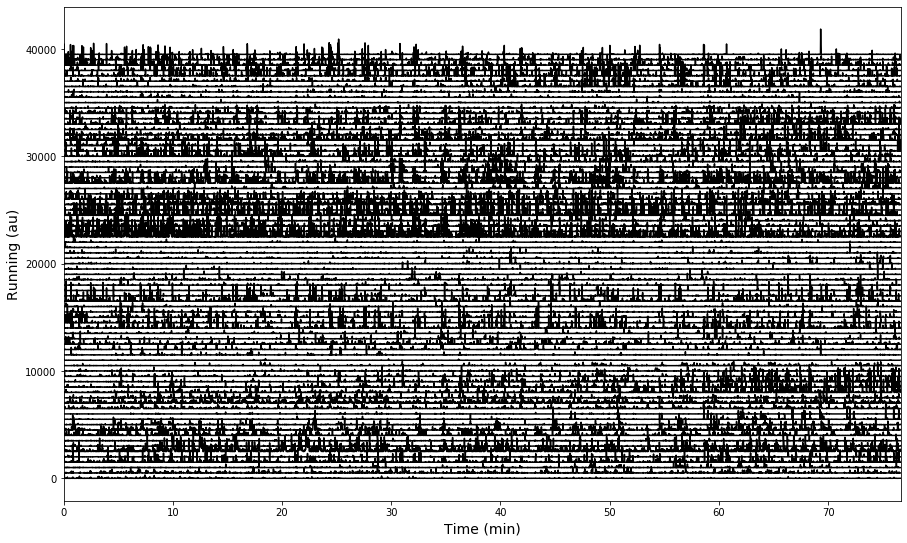

In [ ]:
fig = plt.figure(figsize = (15,20))
[b,a] = butter(4, 0.05, 'lowpass')
plt.subplot(2,1,1)
for i in np.arange(80):
    plt.plot(np.arange(len(dat['run']))/60, dat['sresp'][i] + i*5e2, 'k')
plt.xlim([0, len(dat['run'])/60])
plt.ylabel('Running (au)', fontsize = 14)
plt.xlabel('Time (min)', fontsize = 14)